# Unified Model Architecture

Input Image
   → Pretrained YOLO (Feature Extraction + Bounding Box Predictions)
      → ROI Pooling Layer (Extract Features for Each Bounding Box)
         → Classifier Head (Fine-tuned VGG16 or Custom CNN for Defect Classification)
            → Combined Output (Bounding Boxes + Defect Labels)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics tensorflow keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.3/949.3 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

# Data Preprocessing

## Loding dataset

In [ ]:
import zipfile

# Path to the uploaded file
zip_file_path = '/content/train.zip'

# Path to extract the contents
extract_path = '/content/train'

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to {extract_path}")

Files extracted to /content/train


In [ ]:
import zipfile

# Path to the uploaded file
zip_file_path = '/content/test.zip'

# Path to extract the contents
extract_path = '/content/test'

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to {extract_path}")

Files extracted to /content/test


In [ ]:
import os
import tensorflow as tf

# Dataset loader with robustness
def load_dataset(image_dir, label_dir, target_size=(640, 640)):
    images = []
    bboxes = []
    labels = []
    missing_labels = []
    corrupt_labels = []

    for img_file in os.listdir(image_dir):
        try:
            # Load image
            img_path = os.path.join(image_dir, img_file)
            image = tf.io.read_file(img_path)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, target_size) / 255.0  # Normalize to [0, 1]

            # Load corresponding label
            label_file = os.path.join(label_dir, img_file.replace('.jpg', '.txt'))
            if not os.path.exists(label_file):
                missing_labels.append(img_file)
                continue  # Skip if label file is missing

            with open(label_file, 'r') as f:
                label_data = f.readlines()

            bbox = []
            class_ids = []
            for line in label_data:
                try:
                    # Parse YOLO label format
                    class_id, x_center, y_center, width, height = map(float, line.strip().split())
                    class_ids.append(int(class_id))

                    # Convert YOLO format to [x_min, y_min, x_max, y_max]
                    x_min = (x_center - width / 2) * target_size[0]
                    y_min = (y_center - height / 2) * target_size[1]
                    x_max = (x_center + width / 2) * target_size[0]
                    y_max = (y_center + height / 2) * target_size[1]
                    bbox.append([x_min, y_min, x_max, y_max])
                except ValueError:
                    corrupt_labels.append(label_file)
                    break  # Skip this image if label parsing fails

            if bbox:  # Add only if bounding boxes are valid
                images.append(image)
                bboxes.append(bbox)
                labels.append(class_ids)
        except Exception as e:
            print(f"Error processing file {img_file}: {e}")

    if missing_labels:
        print(f"Missing labels for {len(missing_labels)} images.")
    if corrupt_labels:
        print(f"Corrupt labels in {len(corrupt_labels)} files.")

    return images, bboxes, labels

# Paths to train/test folders
train_image_dir = '/content/drive/MyDrive/Building_Defects/Dataset/train/images'
train_label_dir = '/content/drive/MyDrive/Building_Defects/Dataset/train/labels'
test_image_dir = '/content/drive/MyDrive/Building_Defects/Dataset/test/images'
test_label_dir = '/content/drive/MyDrive/Building_Defects/Dataset/test/labels'

# Load train and test datasets
train_images, train_bboxes, train_labels = load_dataset(train_image_dir, train_label_dir)
test_images, test_bboxes, test_labels = load_dataset(test_image_dir, test_label_dir)

print(f"Loaded {len(train_images)} training images and {len(test_images)} test images.")


Missing labels for 143 images.
Missing labels for 143 images.
Loaded 573 training images and 37 test images.


In [ ]:
import shutil
import os
from sklearn.model_selection import train_test_split

# Paths for train and test datasets
train_images_path = "/content/drive/MyDrive/Building_Defects/train/images"
train_labels_path = "/content/drive/MyDrive/Building_Defects/train/labels"
test_images_path = "/content/drive/MyDrive/Building_Defect/test/images"
test_labels_path = "/content/drive/MyDrive/Building_Defects/test/labels"

combined_images_path = "/content/drive/MyDrive/Building_Defects/Dataset/combined/images"
combined_labels_path = "/content/drive/MyDrive/Building_Defects/Dataset/combined/labels"
"""
# Paths for train and test datasets
train_images_path = "/content/Dataset/train/images"
train_labels_path = "/content/Dataset/train/labels"
test_images_path = "/content/Dataset/test/images"
test_labels_path = "/content/Dataset/test/labels"

combined_images_path = "/content/Dataset/combined/images"
combined_labels_path = "/content/Dataset/combined/labels"
"""

# Create output directories if they don't exist
os.makedirs(train_images_path, exist_ok=True)
os.makedirs(train_labels_path, exist_ok=True)
os.makedirs(test_images_path, exist_ok=True)
os.makedirs(test_labels_path, exist_ok=True)

# Combine all image and label files into one list
all_images = os.listdir(combined_images_path)
all_labels = os.listdir(combined_labels_path)

## Preparing Dataset pipeline

In [ ]:
def create_tf_dataset(images, bboxes, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((images, bboxes, labels))
    dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create train and test datasets
batch_size = 16
train_dataset = create_tf_dataset(train_images, train_bboxes, train_labels, batch_size)
test_dataset = create_tf_dataset(test_images, test_bboxes, test_labels, batch_size)


In [ ]:
def yolo_loss(pred_bboxes, true_bboxes):
    # Replace this with a custom YOLO loss function
    return tf.reduce_mean(tf.square(pred_bboxes - true_bboxes))

def classifier_loss(pred_labels, true_labels):
    return tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(true_labels, pred_labels)

def combined_loss(bbox_loss, label_loss, alpha=1.0, beta=1.0):
    return alpha * bbox_loss + beta * label_loss


In [ ]:
path= '/content/drive/My Drive/Shared with me'

# Define the YOLO + Classifier Model

In [ ]:
train_images_path = "/content/Datasets/train/images"
train_labels_path = "/content/Datasets/train/labels"
test_images_path = "/content/Datasets/test/images"
test_labels_path = "/content/Datasets/test/labels"

In [ ]:
train_images_path

'/content/Datasets/train/images'

In [ ]:
import os
import shutil
"""
# Define your source and destination paths for train and test datasets
train_images_path = "/content/drive/MyDrive/Building_Defects/Dataset/train/images"
train_labels_path = "/content/drive/MyDrive/Building_Defects/Dataset/train/labels"
test_images_path = "/content/drive/MyDrive/Building_Defects/Dataset/test/images"
test_labels_path = "/content/drive/MyDrive/Building_Defects/Dataset/test/labels"
"""

'\n# Define your source and destination paths for train and test datasets\ntrain_images_path = "/content/drive/MyDrive/Building_Defects/Dataset/train/images"\ntrain_labels_path = "/content/drive/MyDrive/Building_Defects/Dataset/train/labels"\ntest_images_path = "/content/drive/MyDrive/Building_Defects/Dataset/test/images"\ntest_labels_path = "/content/drive/MyDrive/Building_Defects/Dataset/test/labels"\n'

In [ ]:
# Paths
# Define your paths
categories = [ 'Overweld', 'Porosity','Undercut', 'Underfilled']
label_map = {0: 'Overweld', 1: 'Porosity', 2: 'Undercut', 3: 'Underfilled'}

In [ ]:
import zipfile

# Path to the uploaded file
zip_file_path = '/content/drive/MyDrive/Datasets-20250107T172536Z-001.zip'

# Path to extract the contents
extract_path = '/content'

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to {extract_path}")


Files extracted to /content


In [ ]:
"""
# Now you can download the zip files
from google.colab import files
files.download('/content/augmented_images_labels.zip')
files.download('/content/augmented_labels.zip')"""

"\n# Now you can download the zip files\nfrom google.colab import files\nfiles.download('/content/augmented_images_labels.zip')\nfiles.download('/content/augmented_labels.zip')"

# Model Training

In [ ]:
!pip install ultralytics

In [ ]:
import os

# Define the directory where your .txt files are stored
annotation_dir = '/content/Datasets/train/labels'  # Change this to your folder path

# Loop through each file in the directory
for filename in os.listdir(annotation_dir):
    if filename.endswith('.txt'):
        file_path = os.path.join(annotation_dir, filename)

        # Open and read the file
        with open(file_path, 'r') as file:
            lines = file.readlines()

        # Create a new list to store modified lines
        modified_lines = []

        for line in lines:
            # Split the line into components: class_id, x_center, y_center, width, height
            parts = line.strip().split()
            # Modify the class_id to be '0' (or any other category)
            parts[0] = '0'  # Change this to the class you want

            # Recreate the modified line and append to the list
            modified_lines.append(" ".join(parts))

        # Overwrite the original file with the modified labels
        with open(file_path, 'w') as file:
            file.write("\n".join(modified_lines))

        print(f"Modified {filename}")

print("All files have been updated")

Modified original_augmented_aug_0_141_IMG-20240305-WA0042.txt
Modified original_augmented_aug_0_145_IMG-20240305-WA0042.txt
Modified original_original_IMG-20240305-WA0059.txt
Modified augmented_aug_3_18_augmented_aug_3_117_IMG-20240305-WA0101.txt
Modified augmented_aug_3_176_augmented_aug_3_117_IMG-20240305-WA0101.txt
Modified original_augmented_aug_0_0_IMG-20240305-WA0042.txt
Modified augmented_aug_0_234_augmented_aug_0_108_IMG-20240305-WA0042.txt
Modified original_augmented_aug_3_100_IMG-20240305-WA0101.txt
Modified original_augmented_aug_1_18_IMG-20240305-WA0073.txt
Modified augmented_aug_2_178_augmented_aug_2_117_IMG-20240305-WA0075.txt
Modified augmented_aug_0_265_augmented_aug_0_108_IMG-20240305-WA0042.txt
Modified original_augmented_aug_1_156_IMG-20240305-WA0073.txt
Modified original_original_u11.txt
Modified original_original_m.txt
Modified original_original_IMG-20240305-WA0014.txt
Modified original_augmented_aug_3_92_IMG-20240305-WA0101.txt
Modified original_augmented_aug_3_99

In [ ]:
import os

# Define the directory where your .txt files are stored
annotation_dir = '/content/Datasets/test/labels'  # Change this to your folder path

# Loop through each file in the directory
for filename in os.listdir(annotation_dir):
    if filename.endswith('.txt'):
        file_path = os.path.join(annotation_dir, filename)

        # Open and read the file
        with open(file_path, 'r') as file:
            lines = file.readlines()

        # Create a new list to store modified lines
        modified_lines = []

        for line in lines:
            # Split the line into components: class_id, x_center, y_center, width, height
            parts = line.strip().split()
            # Modify the class_id to be '0' (or any other category)
            parts[0] = '0'  # Change this to the class you want

            # Recreate the modified line and append to the list
            modified_lines.append(" ".join(parts))

        # Overwrite the original file with the modified labels
        with open(file_path, 'w') as file:
            file.write("\n".join(modified_lines))

        print(f"Modified {filename}")

print("All files have been updated")

Modified augmented_aug_1_236_augmented_aug_1_127_IMG-20240305-WA0073.txt
Modified augmented_aug_1_167_augmented_aug_1_127_IMG-20240305-WA0073.txt
Modified augmented_aug_0_67_augmented_aug_0_108_IMG-20240305-WA0042.txt
Modified augmented_aug_2_153_augmented_aug_2_117_IMG-20240305-WA0075.txt
Modified augmented_aug_0_190_augmented_aug_0_108_IMG-20240305-WA0042.txt
Modified original_augmented_aug_2_158_IMG-20240305-WA0075.txt
Modified original_augmented_aug_0_185_IMG-20240305-WA0042.txt
Modified augmented_aug_1_16_augmented_aug_1_127_IMG-20240305-WA0073.txt
Modified original_augmented_aug_0_65_IMG-20240305-WA0042.txt
Modified original_augmented_aug_0_170_IMG-20240305-WA0042.txt
Modified original_augmented_aug_2_51_IMG-20240305-WA0075.txt
Modified augmented_aug_1_48_augmented_aug_1_127_IMG-20240305-WA0073.txt
Modified augmented_aug_0_267_augmented_aug_0_108_IMG-20240305-WA0042.txt
Modified original_original_IMG-20240305-WA0006.txt
Modified augmented_aug_3_89_augmented_aug_3_117_IMG-20240305

## Yolo8s

In [ ]:
from ultralytics import YOLO
import torch

# Path to your dataset's YAML file
data_yaml_path = '/content/data (1).yaml'  # Ensure this YAML file is correctly configured

# Load YOLOv8 model with pre-trained weights
model = YOLO("yolov8s.pt")  # Using YOLOv8 weights

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 213MB/s]


In [ ]:
# Train the model
model.train(
    data=data_yaml_path,      # Path to dataset YAML
    epochs=20,               # Train for more epochs
    batch=16,                  # Experiment with batch sizes
    imgsz=640,               # Higher resolution images
    device='cuda' if torch.cuda.is_available() else 'cpu',  # Device
    lr0=0.001,                # Initial learning rate
    optimizer='AdamW',          # Optimizer choice (try 'AdamW' for experimentation)
    #augment=True,             # Enable augmentations
    freeze=[0, 1, 2],         # Freeze first few layers
)

Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/data (1).yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=[0, 1, 2], multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

100%|██████████| 755k/755k [00:00<00:00, 22.3MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 99.0MB/s]


AMP: checks passed ✅


train: Scanning /content/Datasets/train/labels... 1600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1600/1600 [00:01<00:00, 974.95it/s]


train: New cache created: /content/Datasets/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/Datasets/test/labels... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:01<00:00, 331.75it/s]


val: New cache created: /content/Datasets/test/labels.cache
Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.89G       1.51      2.012      1.679         29        640: 100%|██████████| 100/100 [00:54<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]

                   all        400        406      0.982       0.93      0.957      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         3G     0.8807     0.6692      1.179         34        640: 100%|██████████| 100/100 [00:47<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]

                   all        400        406      0.986      0.933      0.957      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.7G     0.7362     0.5489      1.096         32        640: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]

                   all        400        406      0.982      0.946      0.969      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.85G     0.6686     0.4907      1.049         32        640: 100%|██████████| 100/100 [00:50<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]

                   all        400        406      0.975      0.944      0.971      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.86G     0.6146     0.4508      1.018         31        640: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]

                   all        400        406      0.979      0.963      0.977      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.85G     0.5589     0.4186     0.9934         40        640: 100%|██████████| 100/100 [00:48<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]

                   all        400        406      0.969      0.961      0.973      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.87G     0.5446     0.4034      0.988         36        640: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.51it/s]

                   all        400        406      0.978      0.963      0.979      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.85G     0.5117     0.3767      0.972         36        640: 100%|██████████| 100/100 [00:48<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]

                   all        400        406      0.997       0.93      0.976      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.85G     0.4829     0.3593     0.9541         39        640: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]

                   all        400        406      0.991      0.966      0.984      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.86G     0.4505     0.3363     0.9458         36        640: 100%|██████████| 100/100 [00:45<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]

                   all        400        406       0.98      0.969       0.98      0.934


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.86G      0.371     0.2697     0.8738         16        640: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]

                   all        400        406      0.985      0.959       0.98      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.69G      0.363     0.2586     0.8786         16        640: 100%|██████████| 100/100 [00:44<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]

                   all        400        406      0.985      0.963      0.983      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.69G     0.3492     0.2478     0.8661         16        640: 100%|██████████| 100/100 [00:44<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]

                   all        400        406      0.983      0.975      0.986      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.69G     0.3187     0.2277      0.849         16        640: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]

                   all        400        406      0.981       0.97      0.982      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.69G     0.3126     0.2264     0.8485         16        640: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]

                   all        400        406      0.982      0.967      0.981      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.86G     0.2849     0.1998     0.8408         16        640: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


                   all        400        406      0.987      0.967      0.982       0.94

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.86G     0.2746     0.1948     0.8424         16        640: 100%|██████████| 100/100 [00:46<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]

                   all        400        406      0.985      0.973      0.987      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.86G     0.2556     0.1787     0.8318         16        640: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]

                   all        400        406      0.983      0.971      0.987      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.87G     0.2394     0.1692     0.8304         17        640: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.09it/s]

                   all        400        406      0.992      0.978      0.989       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.69G     0.2249     0.1608     0.8241         17        640: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]

                   all        400        406      0.988      0.977      0.988      0.951



20 epochs completed in 0.311 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 22.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


                   all        400        406      0.988      0.977      0.988      0.951
Speed: 0.3ms preprocess, 3.7ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78937f85f250>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

### Evaluation

In [ ]:
import locale

def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!sudo locale-gen en_US.UTF-8
!sudo update-locale LANG=en_US.UTF-8

Generating locales (this might take a while)...
  en_US.UTF-8... done
Generation complete.


In [ ]:
# Path to your trained model (change this to the correct path)
model_path = '/content/runs/detect/train2/weights/best.pt'  # Replace with the correct path to the best model

# Evaluate the model
model = YOLO(model_path)

# Evaluate on the validation dataset.
results = model.val(data=data_yaml_path)

Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/Datasets/test/labels.cache... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


                   all        400        406      0.983       0.98      0.989      0.951
Speed: 0.3ms preprocess, 6.8ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/val


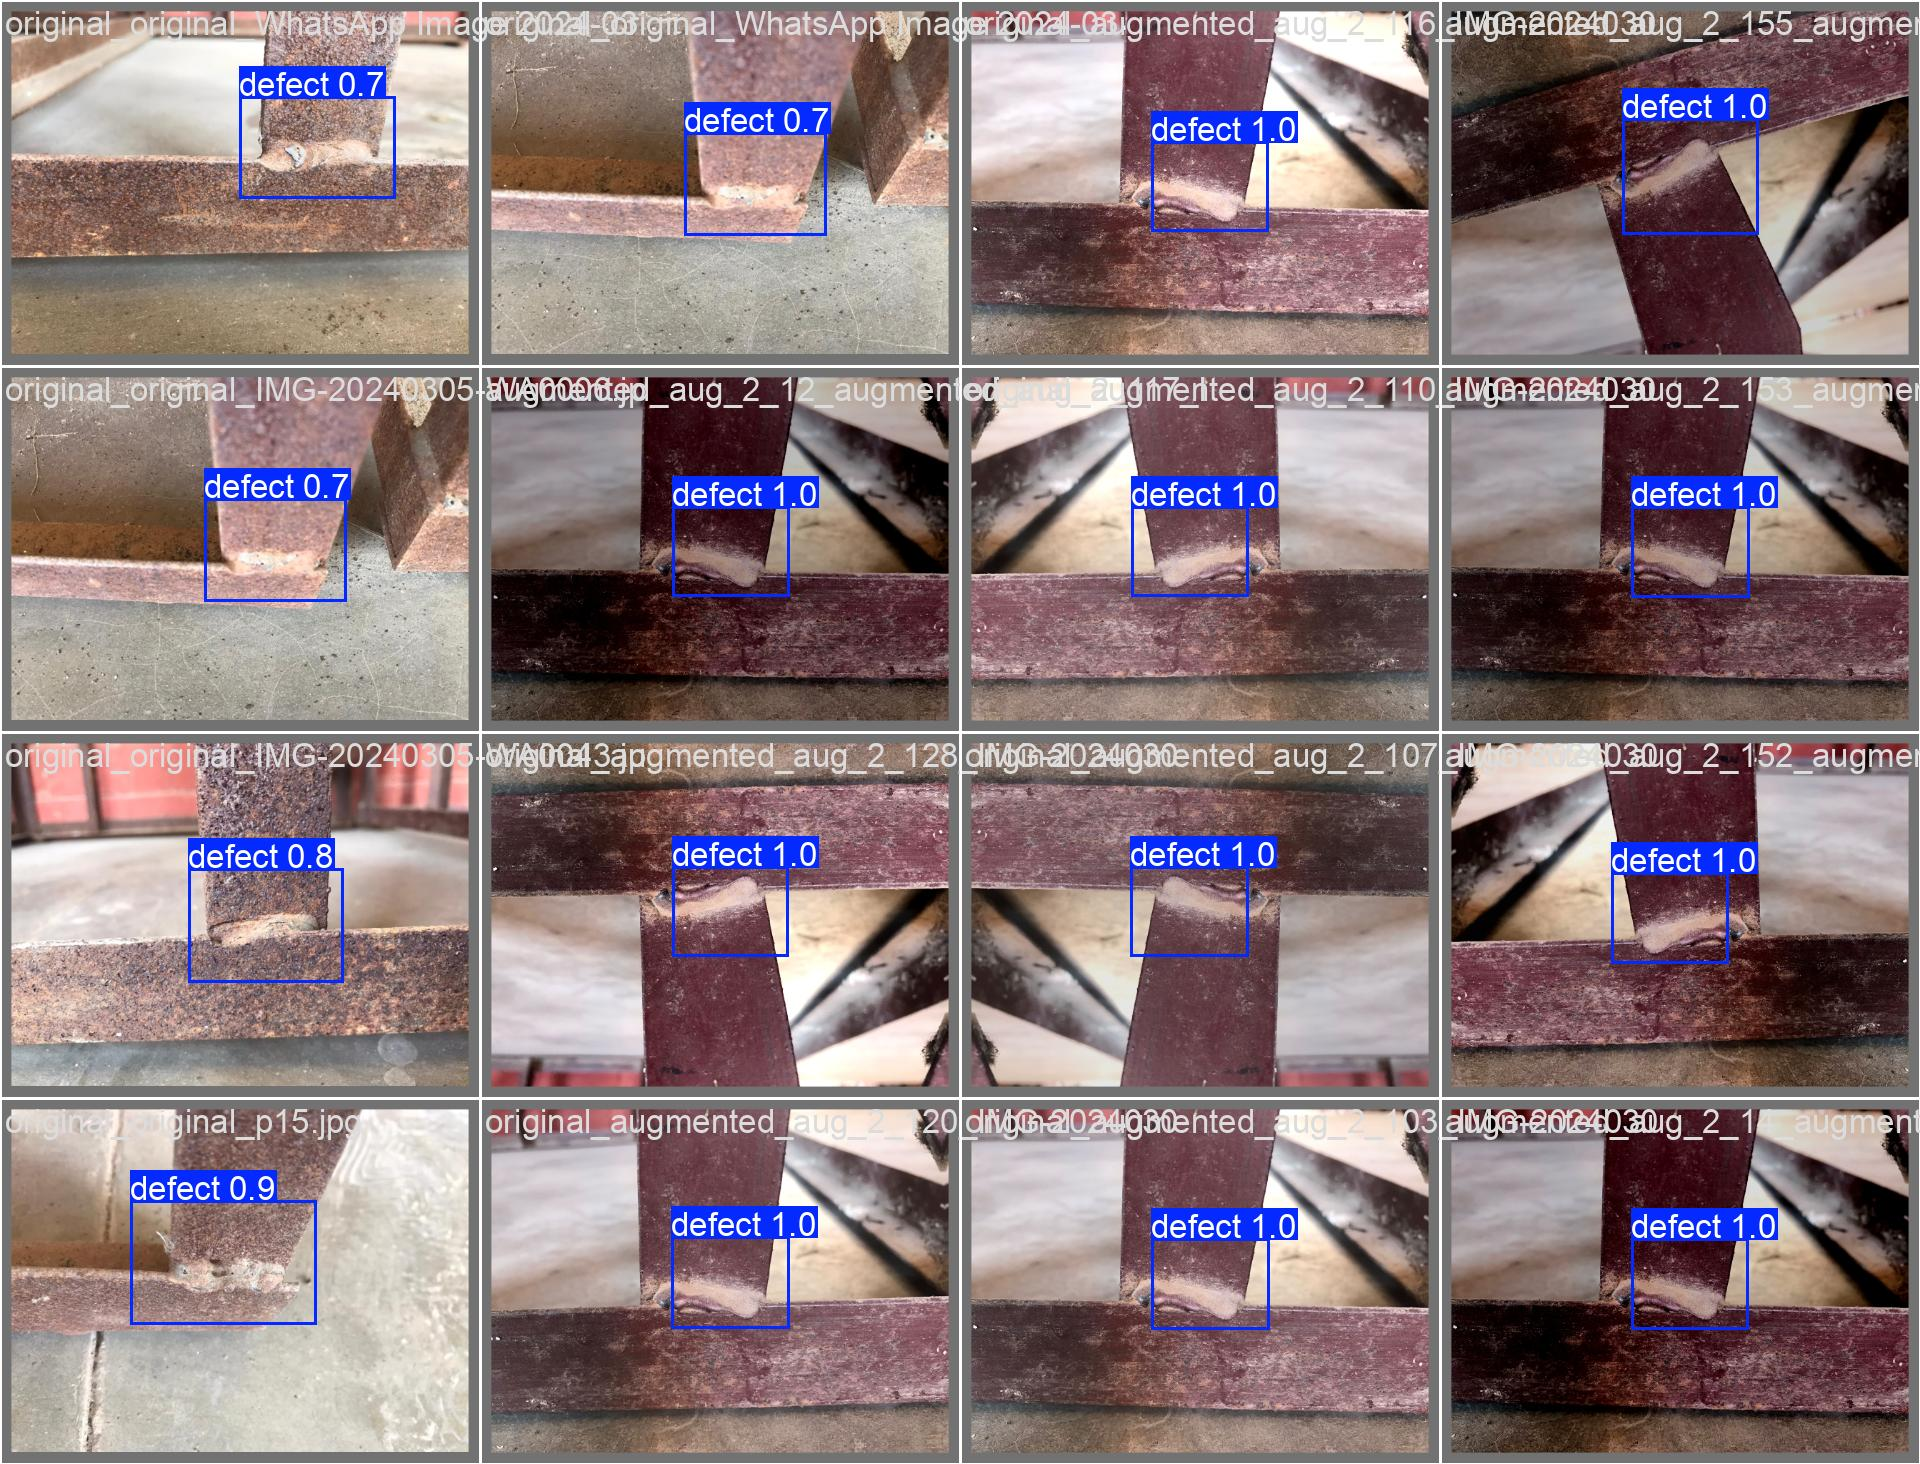

In [ ]:
from IPython.display import Image

# Display an image from the evaluation results
eval_image_path = '/content/runs/detect/val/val_batch0_pred.jpg'  # Change to path of an eval image
Image(filename=eval_image_path)

In [ ]:
# Print the evaluation
# print(results.pandas().xywh)  # This line is causing the error - Remove or comment it
print(results)  # Print the DetMetrics object to see its structure
print(f"mAP@0.5: {results.box.map50}")  # Access mAP@0.5 using results.box.map50
# or print(f"mAP@0.5: {results.box.maps[0.5]}")

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78936df6b490>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
import os
print(os.listdir('/content/runs'))


['detect']


In [ ]:
import zipfile

# Replace 'runs_detects' with the correct folder or file to zip
zip_filename = 'runs_detects.zip'
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    zipf.write('/content/runs')  # Make sure the file/folder exists


In [ ]:
from google.colab import files
files.download('/content/runs_detects.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil

# Specify the folder you want to zip
folder_path = '/content/runs'

# Specify the name of the zip file
zip_filename = 'runs_detect_wwelding.zip'

# Zip the folder
# Adding the path to the zip file name for clarity
shutil.make_archive(os.path.join('/content', zip_filename), 'zip', folder_path)


'/content/runs_detect_wwelding.zip.zip'

## Yolo8n

In [ ]:
from ultralytics import YOLO
import torch

# Path to your dataset's YAML file
data_yaml_path = '/content/data (1).yaml'  # Ensure this YAML file is correctly configured

# Load YOLOv8 model with pre-trained weights
model = YOLO("yolov8n.pt")  # Using YOLOv8 weights


100%|██████████| 6.25M/6.25M [00:00<00:00, 104MB/s]


In [ ]:
# Train the model
model.train(
    data=data_yaml_path,      # Path to dataset YAML
    epochs=20,               # Train for more epochs
    batch=16,                  # Experiment with batch sizes
    imgsz=640,               # Higher resolution images
    device='cuda' if torch.cuda.is_available() else 'cpu',  # Device
    lr0=0.001,                # Initial learning rate
    optimizer='AdamW',          # Optimizer choice (try 'AdamW' for experimentation)
    #augment=True,             # Enable augmentations
    freeze=[0, 1, 2],         # Freeze first few layers
)

Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data (1).yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=[0, 1, 2], multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

100%|██████████| 755k/755k [00:00<00:00, 21.3MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 91.9MB/s]


AMP: checks passed ✅


train: Scanning /content/Datasets/train/labels... 1600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1600/1600 [00:01<00:00, 1153.51it/s]

train: New cache created: /content/Datasets/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/Datasets/test/labels... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:01<00:00, 337.94it/s]


val: New cache created: /content/Datasets/test/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.55G      1.598      1.849      1.743         35        640: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]

                   all        400        406      0.978      0.887      0.958      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.13G      1.063     0.8417      1.276         32        640: 100%|██████████| 100/100 [00:40<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]

                   all        400        406      0.983      0.936      0.959      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.14G     0.8951     0.6807      1.158         25        640: 100%|██████████| 100/100 [00:44<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]

                   all        400        406       0.98      0.963      0.974      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.14G     0.7765     0.6075      1.106         26        640: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

                   all        400        406      0.976       0.97      0.977      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.14G     0.7211     0.5448      1.069         32        640: 100%|██████████| 100/100 [00:40<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]

                   all        400        406       0.98      0.967      0.978      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.14G     0.6622     0.5039       1.05         37        640: 100%|██████████| 100/100 [00:39<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]

                   all        400        406      0.982      0.966      0.979       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.14G     0.6319     0.4842      1.021         28        640: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]

                   all        400        406      0.989      0.966      0.979       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.14G     0.6084     0.4623      1.024         37        640: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]

                   all        400        406      0.982      0.966      0.977      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.14G     0.5528     0.4134     0.9904         29        640: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.32it/s]

                   all        400        406       0.99      0.968      0.979      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.14G     0.5226     0.3909     0.9674         34        640: 100%|██████████| 100/100 [00:39<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


                   all        400        406      0.982      0.952      0.975      0.904
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.14G     0.4328     0.3252      0.897         16        640: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


                   all        400        406      0.982      0.963      0.975      0.898

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.16G     0.4239     0.2984     0.8971         16        640: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]

                   all        400        406       0.99      0.962      0.977      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.16G      0.378     0.2754     0.8792         16        640: 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]

                   all        400        406      0.984      0.973      0.983      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.17G     0.3524     0.2629     0.8595         16        640: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]

                   all        400        406      0.992       0.97      0.984      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.17G     0.3449     0.2544     0.8556         16        640: 100%|██████████| 100/100 [00:36<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.08it/s]

                   all        400        406      0.992      0.965      0.985      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.17G     0.3272     0.2346     0.8526         16        640: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.77it/s]

                   all        400        406       0.99      0.965      0.985      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.19G     0.3077     0.2214     0.8409         16        640: 100%|██████████| 100/100 [00:38<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.87it/s]

                   all        400        406      0.987      0.975       0.98      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.19G     0.2782      0.206     0.8377         16        640: 100%|██████████| 100/100 [00:38<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]

                   all        400        406      0.987      0.971      0.984      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.21G     0.2727      0.202      0.836         17        640: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]

                   all        400        406       0.99      0.967      0.984      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.21G     0.2497     0.1879     0.8339         17        640: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]

                   all        400        406       0.99      0.968      0.985      0.944



20 epochs completed in 0.263 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


                   all        400        406       0.99      0.967      0.984      0.947
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ee2837d5490>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
# Path to your trained model (change this to the correct path)
model_path = '/content/runs/detect/train/weights/best.pt'  # Replace with the correct path

# Evaluate the model
model = YOLO(model_path)

# Evaluate on the validation dataset (it automatically uses the val split from your YAML file)
results = model.val(data=data_yaml_path)

Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/Datasets/test/labels.cache... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


                   all        400        406      0.987      0.968      0.984      0.947
Speed: 1.8ms preprocess, 5.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val


In [ ]:
from google.colab import files
files.download('/content/runs_detect_wwelding.zip.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Yolov8l

In [ ]:
from ultralytics import YOLO
import torch

# Path to your dataset's YAML file
data_yaml_path = '/content/data (1).yaml'  # Ensure this YAML file is correctly configured

# Load YOLOv8 model with pre-trained weights
model2 = YOLO("yolov8l.pt")

100%|██████████| 83.7M/83.7M [00:00<00:00, 137MB/s]


In [ ]:
# Train the model
model2.train(
    data=data_yaml_path,      # Path to dataset YAML
    epochs=20,               # Train for more epochs
    batch=16,                  # Experiment with batch sizes
    imgsz=640,               # Higher resolution images
    device='cuda' if torch.cuda.is_available() else 'cpu',  # Device
    lr0=0.001,                # Initial learning rate
    optimizer='AdamW',          # Optimizer choice (try 'AdamW' for experimentation)
    #augment=True,             # Enable augmentations
    freeze=[0, 1, 2],         # Freeze first few layers
)

Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/data (1).yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=[0, 1, 2], multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

train: Scanning /content/Datasets/train/labels.cache... 1600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1600/1600 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Datasets/test/labels.cache... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       6.8G      1.378       1.29      1.724         35        640: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]

                   all        400        406       0.78      0.665      0.621       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      9.05G     0.9039     0.6563      1.333         32        640: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]

                   all        400        406      0.936      0.771      0.845      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      9.09G     0.7913     0.5872      1.226         25        640: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]

                   all        400        406      0.973      0.916      0.953      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      9.09G     0.7142     0.5427      1.202         26        640: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]

                   all        400        406      0.905      0.912      0.928      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      9.13G     0.6544     0.4839      1.128         32        640: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]

                   all        400        406      0.987      0.946      0.972      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      9.17G     0.5971     0.4168      1.101         37        640: 100%|██████████| 100/100 [01:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]

                   all        400        406      0.964      0.904      0.963       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      9.17G     0.5579     0.4067      1.069         28        640: 100%|██████████| 100/100 [01:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]

                   all        400        406      0.986      0.914      0.954      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      9.21G      0.502     0.3675      1.039         37        640: 100%|██████████| 100/100 [01:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]

                   all        400        406      0.992      0.941      0.971       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      9.22G      0.468     0.3294       1.02         29        640: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]

                   all        400        406      0.985      0.945      0.973      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      9.22G     0.4414     0.3097     0.9984         34        640: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]

                   all        400        406      0.979      0.946      0.961      0.903


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      9.22G     0.3923     0.2829      1.003         16        640: 100%|██████████| 100/100 [01:09<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]

                   all        400        406      0.985      0.952       0.97      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      9.22G     0.3597     0.2556     0.9608         16        640: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]

                   all        400        406      0.985      0.954      0.967       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      9.22G     0.3438     0.2359     0.9473         16        640: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]

                   all        400        406      0.966      0.963       0.98      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      9.22G     0.3183     0.2247     0.9337         16        640: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]

                   all        400        406      0.992      0.958      0.982      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      9.22G     0.3076     0.2111     0.9186         16        640: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]

                   all        400        406      0.989      0.956      0.977      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      9.22G     0.2824     0.1949     0.9065         16        640: 100%|██████████| 100/100 [01:07<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]

                   all        400        406      0.977       0.96      0.975       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      9.24G     0.2646     0.1825     0.8975         16        640: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]

                   all        400        406      0.982      0.965      0.977      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      9.24G     0.2504     0.1672     0.8912         16        640: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]

                   all        400        406      0.982      0.961       0.98      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      9.24G     0.2431     0.1653     0.8865         17        640: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]

                   all        400        406      0.992      0.965      0.982      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      9.24G     0.2193     0.1528      0.879         17        640: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]

                   all        400        406       0.99      0.966      0.983      0.945



20 epochs completed in 0.472 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 87.6MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 87.6MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


                   all        400        406       0.99      0.966      0.983      0.945
Speed: 0.3ms preprocess, 12.5ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ee26e401290>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
# Path to your trained model (change this to the correct path)
model_path2 = '/content/runs/detect/train2/weights/best.pt'  # Replace with the correct path

# Evaluate the model
model2 = YOLO(model_path2)

# Evaluate on the validation dataset (it automatically uses the val split from your YAML file)
results2 = model2.val(data=data_yaml_path)

Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs


val: Scanning /content/Datasets/test/labels.cache... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


                   all        400        406       0.99      0.966      0.983      0.945
Speed: 2.2ms preprocess, 28.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val5


## Yolov8m

In [ ]:
from ultralytics import YOLO
import torch

# Path to your dataset's YAML file
data_yaml_path = '/content/data (1).yaml'  # Ensure this YAML file is correctly configured

# Load YOLOv8 model with pre-trained weights
model3 = YOLO("yolov8m.pt")

100%|██████████| 49.7M/49.7M [00:00<00:00, 352MB/s]


In [ ]:
# Train the model
model3.train(
    data=data_yaml_path,      # Path to dataset YAML
    epochs=20,               # Train for more epochs
    batch=16,                  # Experiment with batch sizes
    imgsz=640,               # Higher resolution images
    device='cuda' if torch.cuda.is_available() else 'cpu',  # Device
    lr0=0.001,                # Initial learning rate
    optimizer='AdamW',          # Optimizer choice (try 'AdamW' for experimentation)
    #augment=True,             # Enable augmentations
    freeze=[0, 1, 2],         # Freeze first few layers
)

New https://pypi.org/project/ultralytics/8.3.94 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/data (1).yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=[0, 1, 2], multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fram

train: Scanning /content/Datasets/train/labels.cache... 1600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1600/1600 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Datasets/test/labels.cache... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.36G      1.462      1.302      1.783         35        640: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]

                   all        400        406      0.965      0.909      0.939      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.78G     0.8486     0.5953      1.277         32        640: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]

                   all        400        406      0.937      0.917      0.955      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.79G     0.7529     0.5274      1.205         25        640: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.08it/s]

                   all        400        406      0.987      0.909      0.943      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.79G     0.6735     0.4846       1.17         26        640: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]

                   all        400        406      0.984      0.914      0.943      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.79G     0.6109     0.4347        1.1         32        640: 100%|██████████| 100/100 [00:47<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]

                   all        400        406      0.977      0.953      0.972      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.86G     0.5762      0.393      1.087         37        640: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.20it/s]

                   all        400        406       0.99      0.916      0.955      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.93G     0.5481      0.389      1.059         28        640: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]

                   all        400        406      0.992      0.921      0.969      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.99G     0.4964     0.3533      1.037         37        640: 100%|██████████| 100/100 [00:47<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]

                   all        400        406       0.98      0.943      0.971      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      7.06G     0.4613     0.3198      1.022         29        640: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]

                   all        400        406      0.977       0.97      0.974      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      7.13G     0.4439     0.3102     0.9998         34        640: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]

                   all        400        406      0.985       0.96      0.976      0.902


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       7.2G     0.3887     0.2669      1.001         16        640: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]

                   all        400        406       0.98      0.955      0.974      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      7.26G     0.3534     0.2458     0.9564         16        640: 100%|██████████| 100/100 [00:46<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]

                   all        400        406      0.983      0.966      0.979      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      7.33G      0.343     0.2353     0.9557         16        640: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]

                   all        400        406      0.992      0.973      0.981      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      7.36G     0.3231     0.2264     0.9404         16        640: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]

                   all        400        406      0.992      0.963      0.981      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      7.36G     0.3111     0.2138     0.9225         16        640: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.21it/s]

                   all        400        406      0.979      0.966      0.985      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      7.36G     0.2853     0.1932       0.91         16        640: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.27it/s]

                   all        400        406       0.98      0.966      0.981      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      7.36G     0.2702     0.1862     0.9009         16        640: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]

                   all        400        406      0.979      0.975      0.985      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      7.36G      0.251     0.1713      0.894         16        640: 100%|██████████| 100/100 [00:47<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.28it/s]

                   all        400        406       0.98      0.973       0.98      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      7.36G     0.2448     0.1646     0.8872         17        640: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.04it/s]

                   all        400        406      0.989       0.97      0.984      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      7.36G      0.222     0.1558     0.8792         17        640: 100%|██████████| 100/100 [00:46<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.05it/s]

                   all        400        406      0.985      0.968       0.98      0.945



20 epochs completed in 0.332 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 52.0MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


                   all        400        406      0.979      0.975      0.985      0.945
Speed: 0.2ms preprocess, 7.9ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ee2831878d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
# Path to your trained model (change this to the correct path)
model_path3 = '/content/runs/detect/train3/weights/best.pt'  # Replace with the correct path

# Evaluate the model
model3 = YOLO(model_path3)

# Evaluate on the validation dataset (it automatically uses the val split from your YAML file)
results3 = model3.val(data=data_yaml_path)

Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/Datasets/test/labels.cache... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]


                   all        400        406      0.979      0.975      0.984      0.945
Speed: 3.0ms preprocess, 16.8ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val4
